In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import statsmodels.stats.api as sms

from scipy.stats import norm
from scipy.stats import t
from scipy import stats

### Exploration of dataset about annual deaths by clinic

In [2]:
yearly = pd.read_csv('yearly_deaths_by_clinic.csv')
yearly.head(10)

,year,births,deaths,clinic
0,1841,3036,237,clinic 1
1,1842,3287,518,clinic 1
2,1843,3060,274,clinic 1
3,1844,3157,260,clinic 1
4,1845,3492,241,clinic 1
5,1846,4010,459,clinic 1
6,1841,2442,86,clinic 2
7,1842,2659,202,clinic 2
8,1843,2739,164,clinic 2
9,1844,2956,68,clinic 2


In [3]:
yearly['proportion_deaths'] = yearly['deaths'] / yearly['births']
yearly

,year,births,deaths,clinic,proportion_deaths
0,1841,3036,237,clinic 1,0.078063
1,1842,3287,518,clinic 1,0.157591
2,1843,3060,274,clinic 1,0.089542
3,1844,3157,260,clinic 1,0.082357
4,1845,3492,241,clinic 1,0.069015
5,1846,4010,459,clinic 1,0.114464
6,1841,2442,86,clinic 2,0.035217
7,1842,2659,202,clinic 2,0.075968
8,1843,2739,164,clinic 2,0.059876
9,1844,2956,68,clinic 2,0.023004


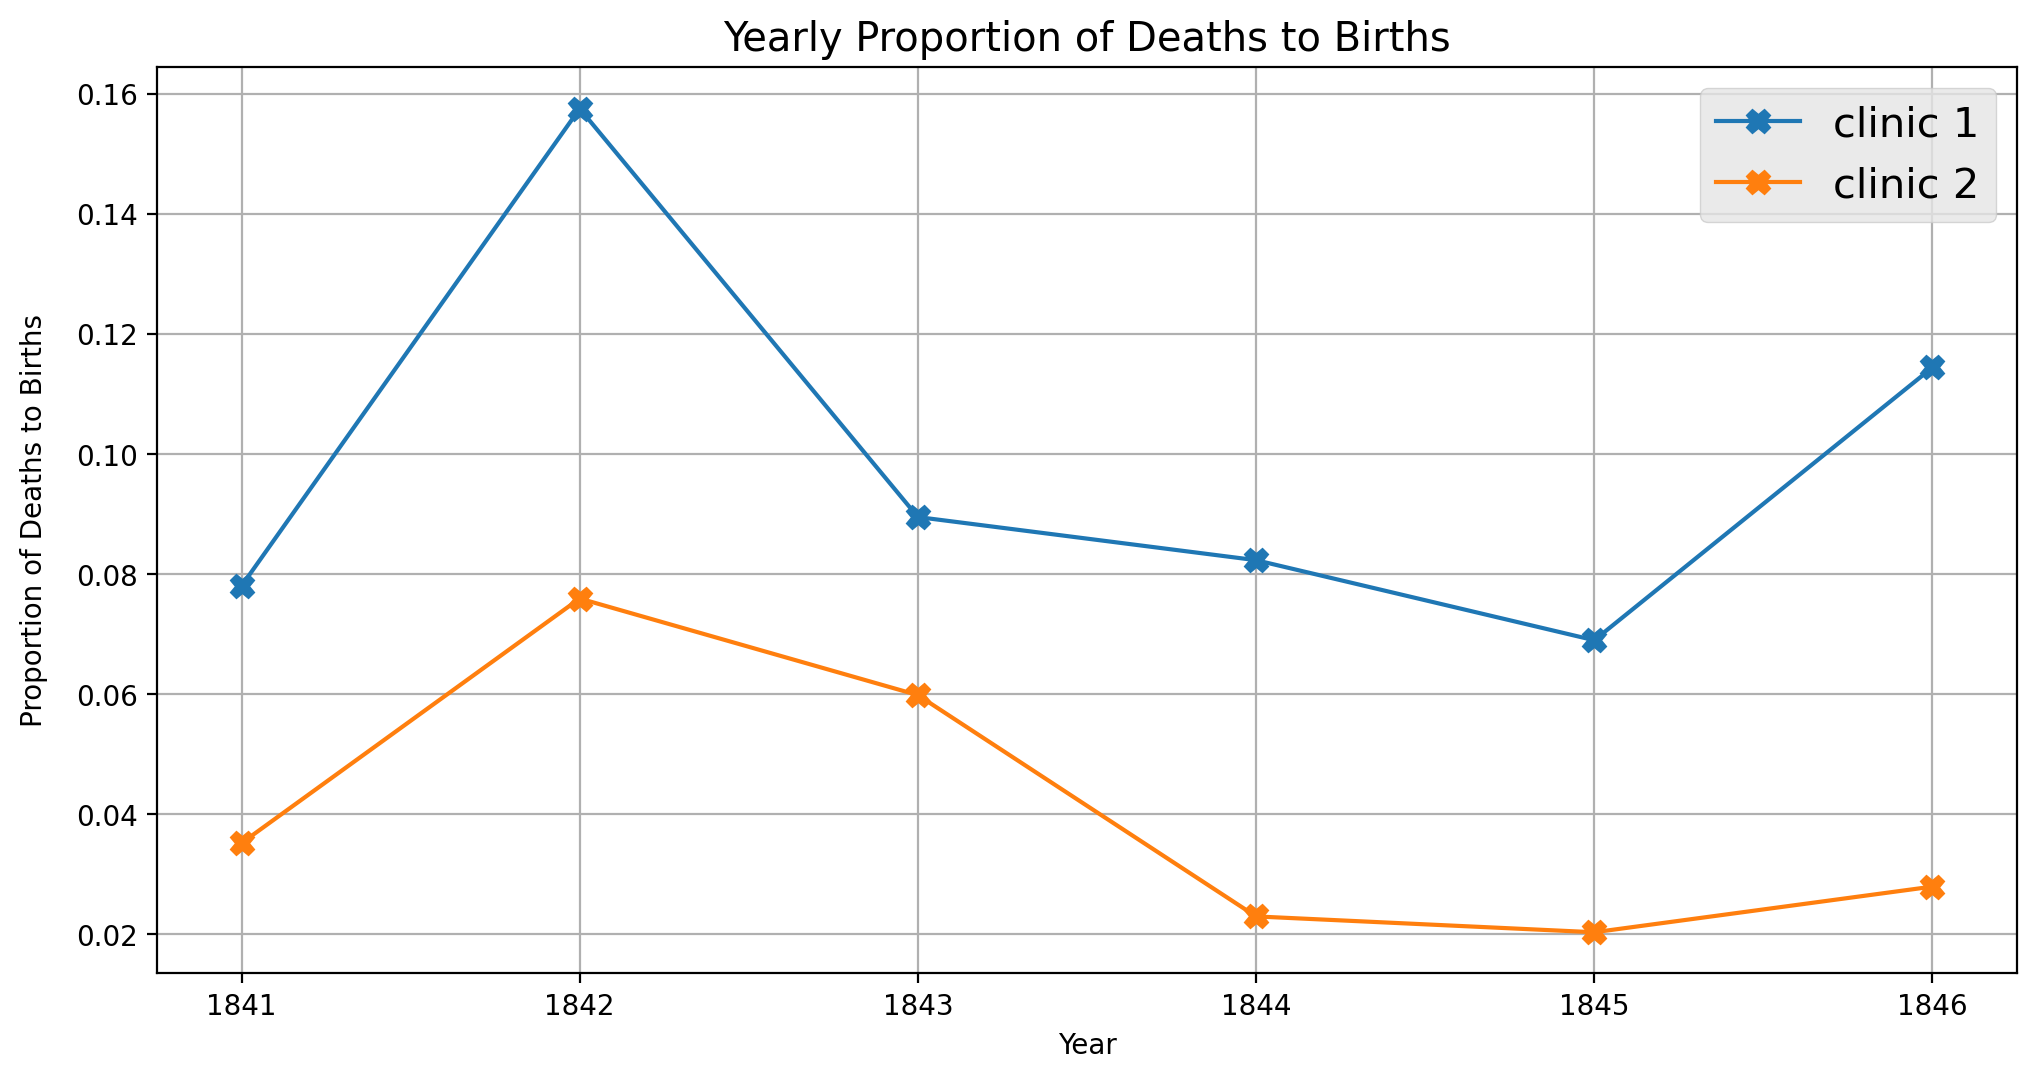

In [4]:
fig, ax = plt.subplots(figsize = (12, 6), dpi = 200)
plt.style.use('ggplot')

for clinic, group in yearly.groupby('clinic'):
    group.plot(x = 'year', y = 'proportion_deaths', ax = ax, label = clinic, marker = 'X', markersize = 8)

plt.title('Yearly Proportion of Deaths to Births')
plt.xlabel('Year')
plt.ylabel('Proportion of Deaths to Births', labelpad = 10)
plt.legend(fontsize = 15)

plt.show()

### Exploration of dataset about monthly deaths

In [5]:
monthly = pd.read_csv('monthly_deaths.csv')
monthly.head(10)

,date,births,deaths
0,1841-01-01,254,37
1,1841-02-01,239,18
2,1841-03-01,277,12
3,1841-04-01,255,4
4,1841-05-01,255,2
5,1841-06-01,200,10
6,1841-07-01,190,16
7,1841-08-01,222,3
8,1841-09-01,213,4
9,1841-10-01,236,26


In [6]:
monthly['proportion_deaths'] = monthly['deaths'] / monthly['births']
monthly

,date,births,deaths,proportion_deaths
0,1841-01-01,254,37,0.145669
1,1841-02-01,239,18,0.075314
2,1841-03-01,277,12,0.043321
3,1841-04-01,255,4,0.015686
4,1841-05-01,255,2,0.007843
...,...,...,...,...
93,1848-11-01,310,9,0.029032
94,1848-12-01,373,5,0.013405
95,1849-01-01,403,9,0.022333
96,1849-02-01,389,12,0.030848


#### Reformat dates to make graph more readable

In [7]:
monthly['date'] = pd.to_datetime(monthly['date'])
monthly['date']

0    1841-01-01
1    1841-02-01
2    1841-03-01
3    1841-04-01
4    1841-05-01
        ...    
93   1848-11-01
94   1848-12-01
95   1849-01-01
96   1849-02-01
97   1849-03-01
Name: date, Length: 98, dtype: datetime64[ns]

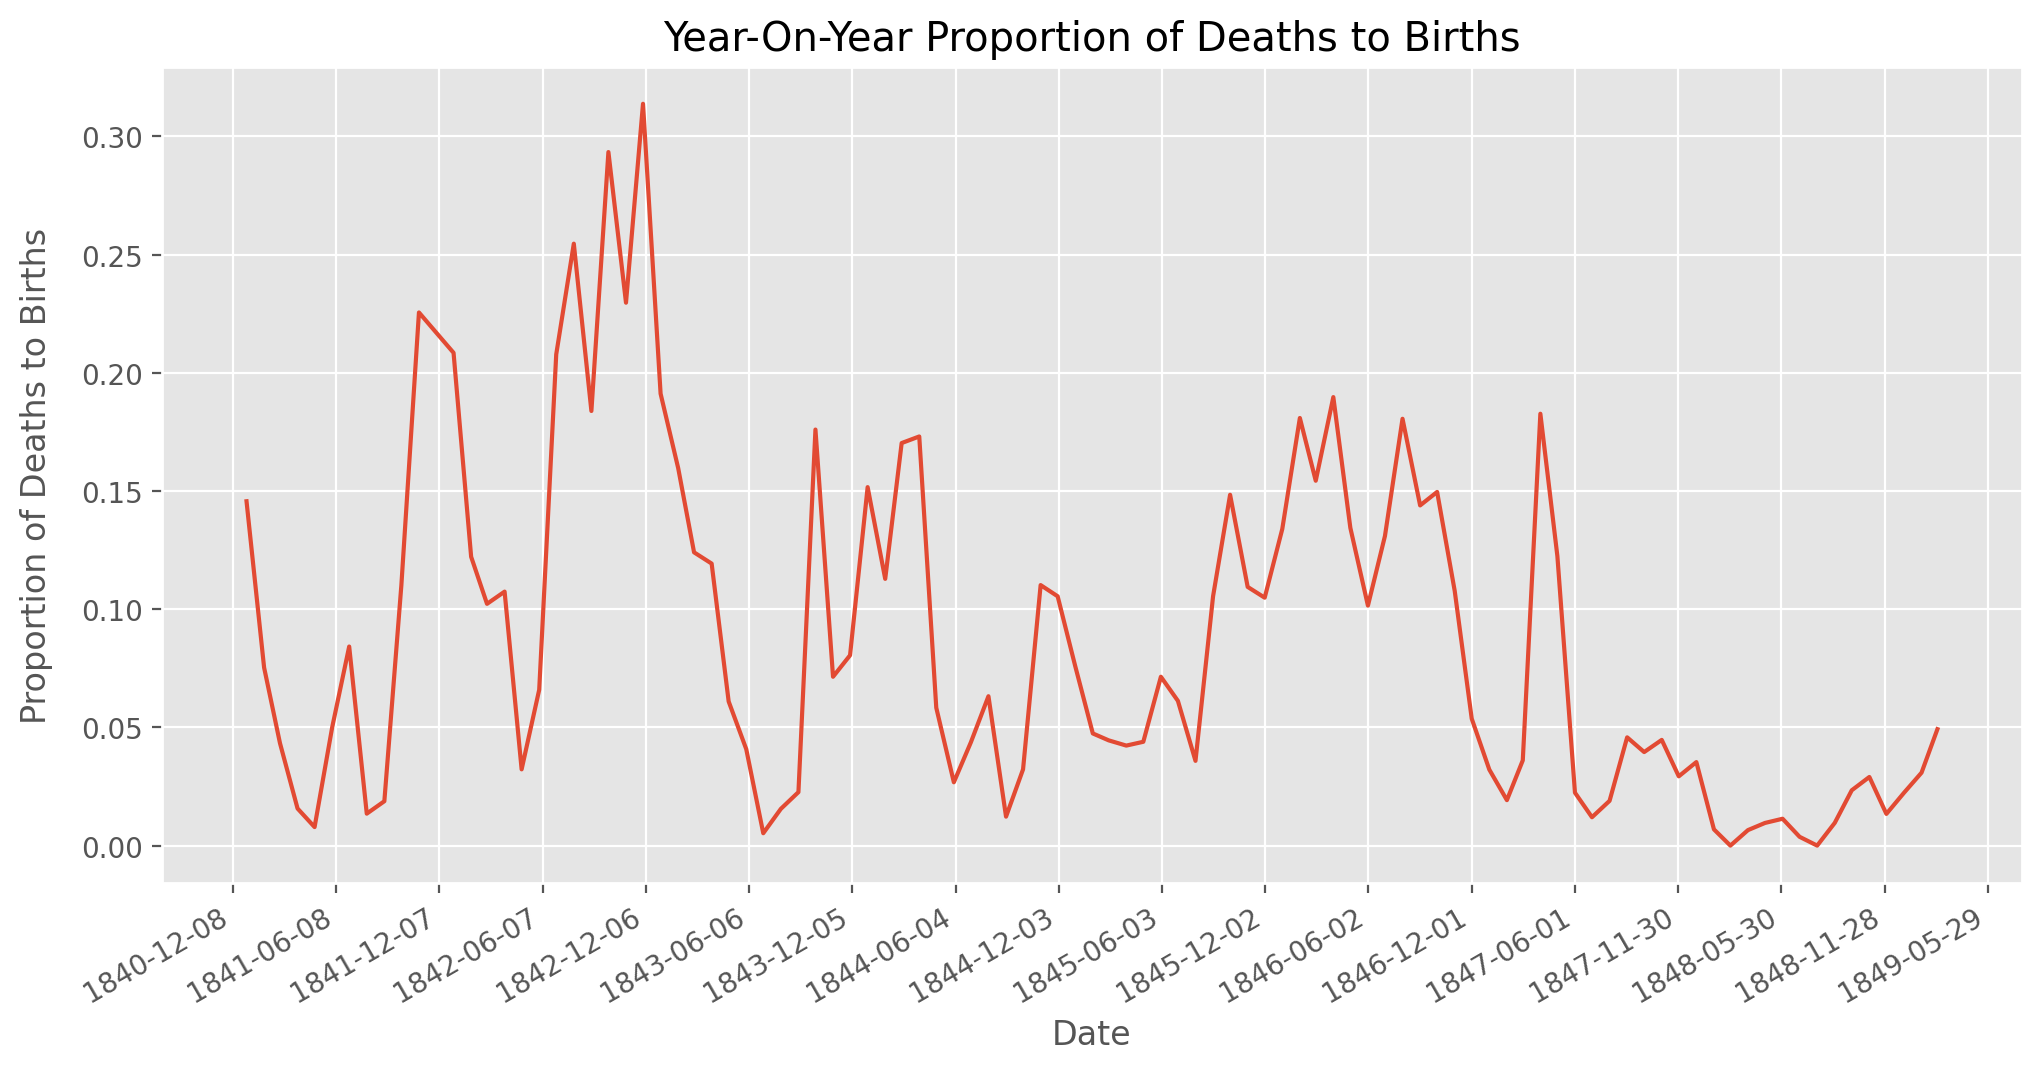

In [8]:
fig = plt.figure(figsize = (12, 6), dpi = 200)
ax = fig.add_subplot(111)
lines = ax.plot(monthly['date'], monthly['proportion_deaths'])

plt.title('Year-On-Year Proportion of Deaths to Births')
plt.xlabel('Date')
plt.ylabel('Proportion of Deaths to Births', labelpad = 10)

ax.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(dates.WeekdayLocator(interval = 26))
plt.gcf().autofmt_xdate()

plt.show()

#### Split Data into 'Before handwashing started' and 'After handwashing started'

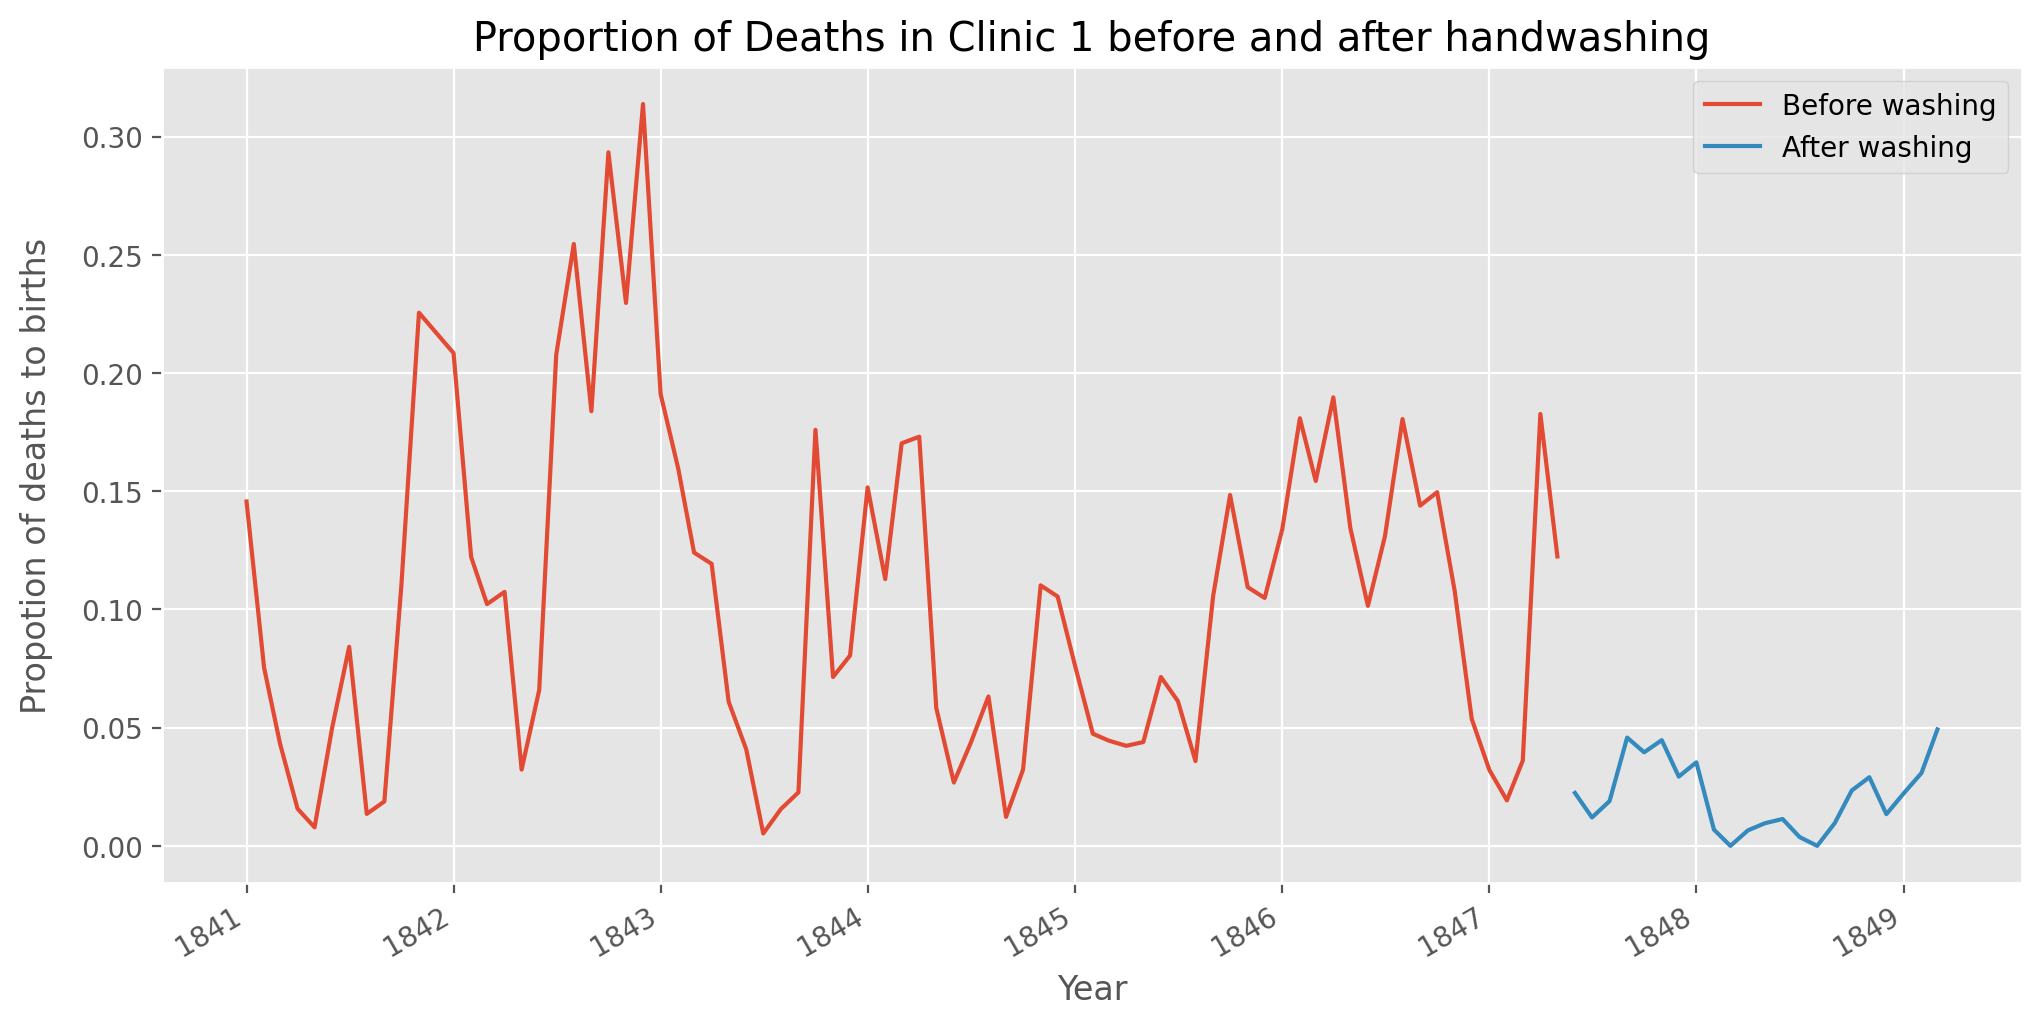

In [9]:
# Date when handwashing was made mandatory
handwashing_start = pd.to_datetime('1847-06-01')

# Split monthly into before and after handwashing_start
before_washing = monthly[monthly['date'] < handwashing_start]
after_washing = monthly[monthly['date'] >= handwashing_start]

# Plot monthly proportion of deaths before and after handwashing
fig, ax = plt.subplots(figsize = (12, 6), dpi = 200)

before_washing.plot(x = 'date', y = 'proportion_deaths', label = 'Before washing', ax = ax)
after_washing.plot(x = 'date', y = 'proportion_deaths', label = 'After washing', ax = ax)

plt.title('Proportion of Deaths in Clinic 1 before and after handwashing')
plt.ylabel('Propotion of deaths to births', labelpad = 10)
plt.xlabel('Year')

plt.legend()
plt.show()

In [10]:
print('Mean Prop. of Deaths to Births Before Handwashing:', round(before_washing['proportion_deaths'].mean(), 4))
print('Mean Prop. of Deaths to Births After Handwashing: ', round(after_washing['proportion_deaths'].mean(), 4))

Mean Prop. of Deaths to Births Before Handwashing: 0.105
Mean Prop. of Deaths to Births After Handwashing:  0.0211


## Perform Welch's Two Sample t-Test to determine whether there is a statistically significant decrease in the proportion of deaths after the start of handwashing

#### Define two relevant arrays of data (Proportion of births to deaths before, and after handwashing started):

In [11]:
bf_wash_propdeaths = before_washing['proportion_deaths']
af_wash_propdeaths = after_washing['proportion_deaths']

#### Perform Welch's t-test (Only returns t-Statistic and P-Value):

In [12]:
t_test = stats.ttest_ind(bf_wash_propdeaths, af_wash_propdeaths, equal_var = False)

print('t-Statistic obtained:', round(t_test.statistic, 4))
print('P-Value obtained:    ', round(t_test.pvalue, 18))

t-Statistic obtained: 9.6101
P-Value obtained:     1.445e-15


#### Obtain the degrees of freedom

In [13]:
def welch_dof(x,y):
    
        dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / 
                                                      (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
            
        print('Welch-Satterthwaite Degrees of Freedom:', round(dof, 3))
        
welch_dof(bf_wash_propdeaths, af_wash_propdeaths)

Welch-Satterthwaite Degrees of Freedom: 92.435


#### Create a 95% Confidence Interval for the difference between mean proportions of deaths to births between before start of handwashing and after start of handwashing

In [14]:
ci = sms.CompareMeans(sms.DescrStatsW(bf_wash_propdeaths), sms.DescrStatsW(af_wash_propdeaths))

lower, upper = ci.tconfint_diff(alpha = 0.05, alternative = 'two-sided', usevar = 'unequal')
print('95% Confidence Interval: [{0:0.8f}, {1:0.8f}]'.format(lower, upper))

95% Confidence Interval: [0.06660662, 0.10130659]


### Conclusion of Hypothesis Test:
<br>
<br>
\begin{align}
\text{Null hypothesis: }H_0: \mu_{\text{After handwash start}} - \mu_{\text{Before handwash start}} = 0 \\
\text{Alternate hypothesis: }H_a: \mu_{\text{After handwash start}} - \mu_{\text{Before handwash start}} \neq 0
\end{align}
<br>

**Null Hypothesis**: True difference in means of proportion of deaths to births before start of handwashing and after start of handwashing **is equal** to 0.<br>
**Alt. Hypothesis**: True difference in means of proportion of deaths to births before start of handwashing and after start of handwashing **is not equal** to 0.

Since the $P$-Value of Welch's t-Test is below the 95% level of significance ($\alpha = 0.05$) with a value of $1.445\times10^{15}$, we reject the null hypothesis and conclude that there is sufficient evidence to prove that the alternate hypothesis is true, meaning that the true difference in the means of proportion of deaths to births before the start of handwashing and after the start of handwashing is not equal to 0, at the 95% level of significance.